# Plot results for paper

Code to generate most of the figures in the paper

In [1]:
import numpy as np
from numpy import linspace, meshgrid
from numpy.fft import fftn, fftfreq, ifftn
from pytket.utils import expectation_from_counts

import matplotlib.pylab as plt
import matplotlib.cm as cm
import matplotlib
import pickle

from collections import Counter

### Some global functions

In [2]:
def load_file(name):
    file = open(name, 'rb')
    res_dict = pickle.load(file)
    file.close()
    return res_dict

In [3]:
def to_dict(res):
    return [dict(r.get_counts().items()) for r in res]

def measure_subset(d, indices):
    r = {}
    for k in d.keys():
        k_ary = np.array(k)
        k_ = tuple(k_ary[indices])
        try:
            r[k_] += d[k]
        except KeyError:
            r[k_] = d[k]
        
    return r

In [4]:
def get_expectation(res_dict, subset_to_measure):
    return np.array([expectation_from_counts(measure_subset(r, subset_to_measure)) for r in res_dict])

In [5]:
def to_fourier(obj, n, M, delta=0):
    a = obj.reshape((n, n))
    C_ = fftn(a)
    phase = np.pi * delta
    phase_vec = np.exp(-1j * xf * phase)
    phase_array = np.outer(phase_vec, phase_vec)
    C = C_ * phase_array / n ** M
    
    return C

In [6]:
def sample_and_measure(r, subset_to_measure, s=1000):
    results = [[k] * v for k, v in r.items()]  # recreate results
    results = [item for sublist in results for item in sublist] #  flatten
    o_lst = []
    for i in range(s):
        ixs = np.random.choice(range(len(results)), len(results))
        tmp = [results[ix] for ix in ixs]
        r_ = dict(Counter(tmp))
        o_lst.append(expectation_from_counts(measure_subset(r_, subset_to_measure)))
    return o_lst

def sample_fourier(res_dict, subset_to_measure, n, M, s=1000, delta=0):
    samples = np.array([sample_and_measure(r, subset_to_measure, s) for r in res_dict])
    samples = samples.reshape((n, n, -1)).transpose((2,0,1))
    samples_fourier = np.array([to_fourier(s, n, M, delta) for s in samples])
    return samples_fourier

# Power measurements

### Breakdown of power in noise modes for $\texttt{ibmq_lima}$

In [7]:
def power_noise_extra_modes(C, C_exact):
    support_exact = C_exact != 0
    mask = abs(xf) != 2
    mask2d = np.outer(mask, mask)
    c = C.copy()
    c[support_exact] = 0
    d = C.copy()
    d[mask2d] = 0  
    
    return np.linalg.norm(C) ** 2, np.linalg.norm(c) ** 2, np.linalg.norm(d) ** 2

In [8]:
# Import results
res_dict_batch = load_file(f"_results/ibmq_lima_2021-10-15-16:47:09_2qubits_2rots_barriers_0_10.pkl")
res_dict_exact = load_file(f"_results/aer_backend_2021-08-18-10:39:09_2qubits_2rots.pkl")[0]  # exact result from simulator run

In [9]:
N = 2
n = 2 * N + 1
M = 2

xf = fftfreq(n, 1./n)

In [10]:
subset_to_measure = [0, 1]

In [11]:
barriers = np.arange(0, 10)

In [12]:
sf_batch = [sample_fourier(rd, subset_to_measure, n, M, s=10) for rd in res_dict_batch]

In [13]:
C_exact = to_fourier(get_expectation(res_dict_exact, subset_to_measure), n=n, M=M).round(2)

In [14]:
P = []
P_std = []
N = []
N_std = []
N_em = []
N_em_std = []
snr = []
snr_std = []
nem2n = []
nem2n_std = []
NP = []
NP_std = []

for sf in sf_batch:
    ps = []
    ns = []
    nems = []
    snrs = []
    nem2ns = []
    nps = []
    for s in sf:
        p, no, nem = power_noise_extra_modes(s, C_exact)
        ps.append(p)
        ns.append(no)
        nems.append(nem)
        snrs.append((p - no)/no)
        nem2ns.append(nem/no)
        nps.append(no/p)
        
    P.append(np.mean(ps))
    P_std.append(np.std(ps))
    N.append(np.mean(ns))
    N_std.append(np.std(ns))
    N_em.append(np.mean(nems))
    N_em_std.append(np.std(nems))
    snr.append(np.mean(snrs))
    snr_std.append(np.std(snrs))
    nem2n.append(np.mean(nem2ns))
    nem2n_std.append(np.std(nem2ns))
    NP.append(np.mean(nps))
    NP_std.append(np.std(nps))

In [15]:
# Noiseless quantities
pnl, nnl, nemnl = power_noise_extra_modes(C_exact, C_exact)
P.append(pnl)
N.append(nnl)
N_em.append(nemnl)
P_std.append(0)
N_std.append(0)
N_em_std.append(0)
snr.append(0)
snr_std.append(0)
nem2n.append(0)
nem2n_std.append(0)
NP.append(0)
NP_std.append(0)

P = np.array(P)
N = np.array(N)
N_em = np.array(N_em)
P_std = np.array(P_std)
N_std = np.array(N_std)
N_em_std = np.array(N_em_std)
snr = np.array(snr)
snr_std = np.array(snr_std)
nem2n = np.array(nem2n)
nem2n_std = np.array(nem2n_std)
NP = np.array(NP)
NP_std = np.array(NP_std)

In [16]:
names = list(barriers.astype(str)) + ["exact"]

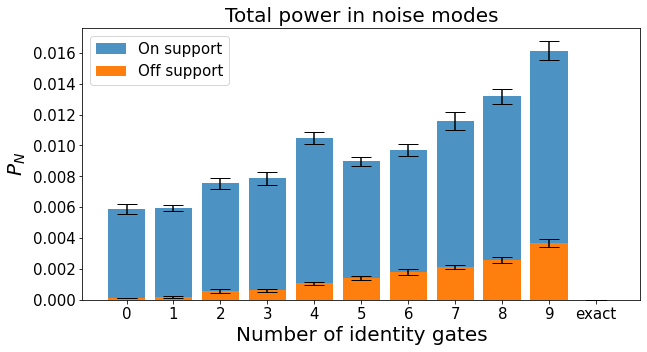

In [17]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(111)

ax1.bar(names, N, yerr=N_std, alpha=0.8, capsize=10, label="On support")
ax1.bar(names, N_em, yerr=N_em_std, alpha=1, capsize=10, label="Off support")
ax1.set_title("Total power in noise modes", size=20)
ax1.set_ylabel("$P_N$", size=20)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.legend(fontsize=15)
ax1.set_xlabel("Number of identity gates", size=20)

plt.show()

### Figures of merit for different computers

In [18]:
names = ["bogota", "lagos", "lima", "santiago", "honeywell"]
files = ["./_results/ibmq_bogota_2021-08-17-13:17:33_XY_YX.pkl",
         "./_results/ibm_lagos_2021-08-17-13:29:41_XY_YX.pkl",
         "./_results/ibmq_lima_2021-08-17-13:15:51_XY_YX.pkl",
         "./_results/ibmq_santiago_2021-05-19-15:57:44.pkl",
         "./_results/HQS-LT-S1_2021-05-21-08:21:21.pkl"]

In [19]:
subset_to_measure = [0]

In [20]:
sf_batch = []
for f in files:
    res_dict = load_file(f)
    sf = sample_fourier(res_dict, subset_to_measure, n, M, s=10)
    sf_batch.append(sf)

In [21]:
P = []
P_std = []
N = []
N_std = []
N_em = []
N_em_std = []
snr = []
snr_std = []
nem2n = []
nem2n_std = []
NP = []
NP_std = []

for sf in sf_batch:
    ps = []
    ns = []
    nems = []
    snrs = []
    nem2ns = []
    nps = []
    for s in sf:
        p, no, nem = power_noise_extra_modes(s, C_exact)
        ps.append(p)
        ns.append(no)
        nems.append(nem)
        snrs.append((p - no)/no)
        nem2ns.append(nem/no)
        nps.append(no/p)
        
    P.append(np.mean(ps))
    P_std.append(np.std(ps))
    N.append(np.mean(ns))
    N_std.append(np.std(ns))
    N_em.append(np.mean(nems))
    N_em_std.append(np.std(nems))
    snr.append(np.mean(snrs))
    snr_std.append(np.std(snrs))
    nem2n.append(np.mean(nem2ns))
    nem2n_std.append(np.std(nem2ns))
    NP.append(np.mean(nps))
    NP_std.append(np.std(nps))

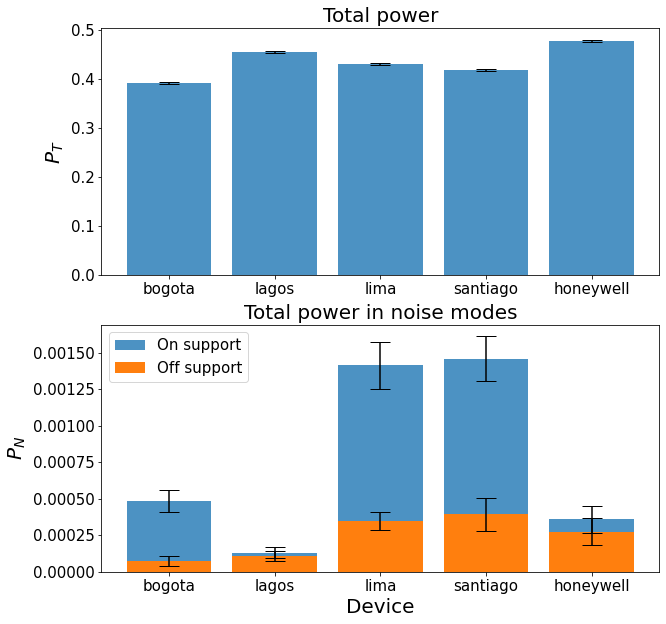

In [22]:
fig = plt.figure(figsize=(10, 10))
ax0 = fig.add_subplot(211)
ax1 = fig.add_subplot(212)

ax0.bar(names, P, yerr=P_std, alpha=0.8, capsize=10)
ax0.set_title("Total power", size=20)
ax0.set_ylabel("$P_T$", size=20)
ax0.tick_params(axis='both', which='major', labelsize=15)

ax1.bar(names, N, yerr=N_std, alpha=0.8, capsize=10, label="On support")
ax1.bar(names, N_em, yerr=N_em_std, alpha=1, capsize=10, label="Off support")
ax1.set_title("Total power in noise modes", size=20)
ax1.set_ylabel("$P_N$", size=20)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.set_xlabel("Device", size=20)
ax1.legend(fontsize=15)

plt.show()

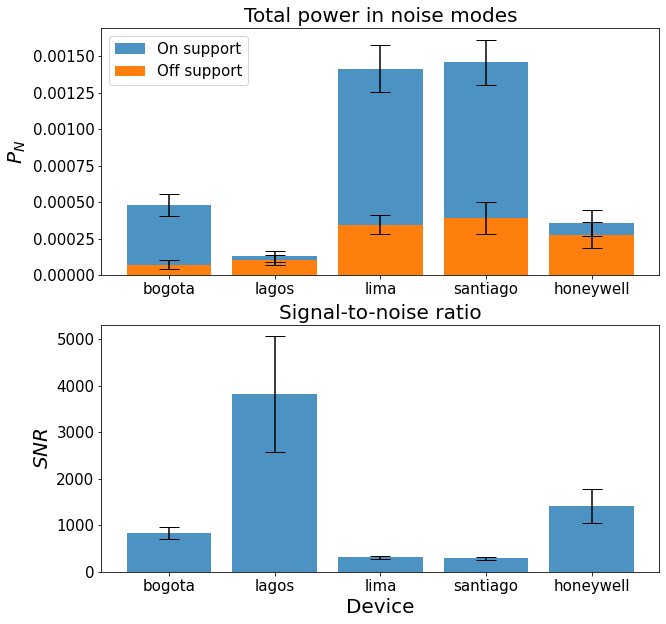

In [23]:
fig = plt.figure(figsize=(10, 10))
ax0 = fig.add_subplot(211)
ax1 = fig.add_subplot(212)

ax0.bar(names, N, yerr=N_std, alpha=0.8, capsize=10, label="On support")
ax0.bar(names, N_em, yerr=N_em_std, alpha=1, capsize=10, label="Off support")
ax0.set_title("Total power in noise modes", size=20)
ax0.set_ylabel("$P_N$", size=20)
ax0.tick_params(axis='both', which='major', labelsize=15)
ax0.legend(fontsize=15)

ax1.bar(names, snr, yerr=snr_std, alpha=0.8, capsize=10)
ax1.set_title("Signal-to-noise ratio", size=20)
ax1.set_ylabel("$SNR$", size=20)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.set_xlabel("Device", size=20)

plt.show()

# [Appendix] Cleaning the coefficients by rounding

In [24]:
def reduce_shots(r, shots=1):
    results = [[k] * v for k, v in r.items()]  # recreate results
    results = [item for sublist in results for item in sublist] #  flatten

    ixs = np.random.choice(range(len(results)), shots, replace=False)
    tmp = [results[ix] for ix in ixs]
    
    r_ = dict(Counter(tmp))
    return r_

In [25]:
res_dict = load_file("./_results/HQS-LT-S1_2021-05-21-08:21:21.pkl")

In [26]:
subset_to_measure = [0]
obj = get_expectation(res_dict, subset_to_measure)

In [27]:
N = 2
M = 2
n = 2 * N + 1
delta = 0.5/n

xf = fftfreq(n, 1./n)

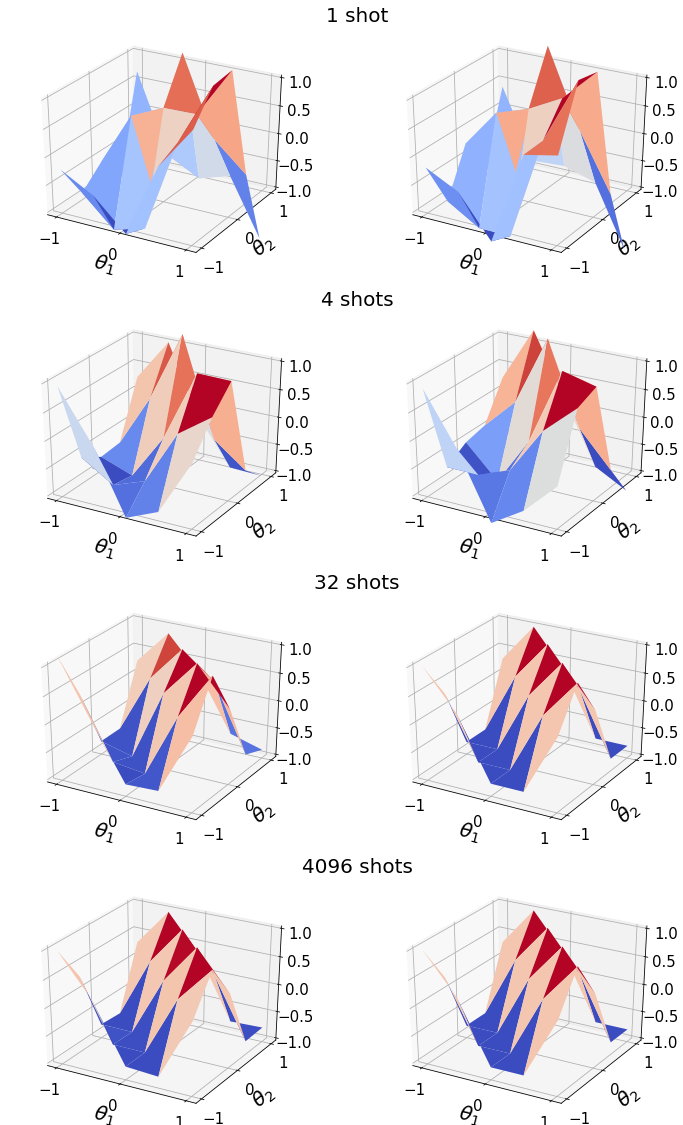

In [28]:
fig = plt.figure(figsize=(12, 20))

for i, exp in enumerate([0, 2, 5, 12]):

    obj_downsampled = np.array([
        expectation_from_counts(measure_subset(reduce_shots(r, int(2 ** exp)), subset_to_measure))
        for r in res_dict
    ]).reshape(n,n)
    C_downsampled = to_fourier(obj_downsampled, n, M, delta)
#     C_round = myround(C_downsampled)
    C_round = C_downsampled.round(1)
    
    ax0 = fig.add_subplot(4, 2, 2 * i + 1, projection="3d")
    ax1 = fig.add_subplot(4, 2, 2 * i + 2, projection="3d")
    # Make data.
    X = np.linspace(-1, 1, 5)
    Y = np.linspace(-1, 1, 5)
    X, Y = np.meshgrid(X, Y)
    Z = (ifftn(C_downsampled) * n ** M).real
    Z_round  = (ifftn(C_round) * n ** M).real

    # Plot the surface.
    ax0.plot_surface(X, Y, Z, cmap=cm.coolwarm)
    if i == 0:
        ax0.set_title(f"{2 ** exp} shot", position=(1.15, 1.1), fontsize=20)
    else:
        ax0.set_title(f"{2 ** exp} shots", position=(1.15, 1.1), fontsize=20)
    ax1.plot_surface(X, Y, Z_round, cmap=cm.coolwarm)
    
    ax0.set_zlim(-1,1)
    ax0.locator_params(nbins=4)
    ax0.set_xlabel(r"$\theta_1$", fontsize=20)
    ax0.set_ylabel(r"$\theta_2$", fontsize=20)
    ax0.tick_params(axis='both', which='major', labelsize=15)

    ax1.set_zlim(-1,1)
    ax1.locator_params(nbins=4)
    ax1.set_xlabel(r"$\theta_1$", fontsize=20)
    ax1.set_ylabel(r"$\theta_2$", fontsize=20)
    ax1.tick_params(axis='both', which='major', labelsize=15)
    
plt.show()